<a href="https://colab.research.google.com/github/aemrhb/IPI_project-seminar/blob/main/faster_Rcnnn_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
%cd gdrive/My Drive/faster-Rccn-finetune

/content/gdrive/My Drive/faster-Rccn-finetune


In [3]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
# !git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [4]:
import torchvision

In [5]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
# from torchvision.datasets import YourCustomDataset
from torch.optim import SGD
import torch.utils.data
import torchvision.transforms as T

In [6]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
# from engine import train_one_epoch, evaluate
# import utils
# import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [7]:
import cv2
import os
from PIL import Image
import numpy as np
import torch
# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw

In [8]:
files_dir = '/content/gdrive/My Drive/faster-Rccn-finetune/data/Kuken_videos-00_0'

In [9]:
imge_path = os.path.join(files_dir, "img1" )
annots_path  = os.path.join(files_dir ,"annot")

In [10]:
# # from torchvision.ops import boxes
# imgs = list(sorted(os.listdir(imge_path)))

# annot_path = os.path.join(files_dir, imgs[1])
# # annot = list(sorted(os.listdir(files_dir)))
# # print(imgs[1][:-4])
# # img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
# img_path = os.path.join(imge_path, imgs[1])
# print(img_path)
# img = cv2.imread(img_path)
# img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
# print(imgs[70])
# print(imgs[70][:-4] + '.txt')
# annot_file = imgs[1][:-4] + '.txt'
# annot_path = os.path.join(annots_path,annot_file)
# print(annot_path)
# with open(annot_path, "r") as file:
#   file_contents = file.read()
# lines = file_contents.split("\n")
# data = np.matrix(lines)
# boxes = []
# labels = []
# area = []

# for i in range(data.shape[1] - 1 ):
#   boxe = []
#   line = data[0,i].split(",")
#   # print(line)
#   strr = line[2:6]
#   res = [float(t) for t in strr]

#   are = int((res[2] - res[0]) * (res[3] - res[1]))
#   area.append(are)
#   boxes.append(res)
#   labels.append(float(line[7]))


# boxes = torch.as_tensor(boxes, dtype=torch.float32)
# labels = torch.as_tensor(labels, dtype=torch.int64)
# area = torch.as_tensor(area, dtype=torch.int64)
# iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
# image_id = torch.tensor([2])


# target = {}


# target["boxes"] = boxes
# target["labels"] = labels
# target["area"] = area
# target["iscrowd"] = iscrowd
# target["image_id"] = image_id
# # image_id
# image_id = torch.tensor([2])
# # print(boxes)
# # print(labels)
# # print(area)
# # print(iscrowd)
# # print(target)
# # print(type(target))



In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files_dir,width, height, transforms=None):  # Add necessary arguments for dataset initialization
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width

        self.imgs = list(sorted(os.listdir(imge_path)))
                        

        
        
    
    def __getitem__(self, idx):
        # Implement dataset item retrieval logic
        imge_path = os.path.join(self.files_dir , "img1" )
        img_name = self.imgs[idx]
        img_path = os.path.join(imge_path, img_name)
        img = cv2.imread(img_path)
        wt = img.shape[1]
        ht = img.shape[0]
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)

        img_res /= 255.0

        
        annots_path  = os.path.join(files_dir ,"annot")
        annot_file = img_name[:-4] + '.txt'
        annot_path = os.path.join(annots_path,annot_file)
        with open(annot_path, "r") as file:
          file_contents = file.read()
        lines = file_contents.split("\n")
        data = np.matrix(lines)
        boxes = []
        labels = []
        area = []

        for i in range(data.shape[1] - 1 ):
          boxe = []
          line = data[0,i].split(",")
          # print(line)
          strr = line[2:6]

          res = [float(t) for t in strr]
            
          xmin_corr = (res[0]/wt)*self.width
          xmax_corr = (res[0]/wt)*self.width + (res[2]/wt)*self.width
          ymin_corr = (res[1]/ht)*self.height
          ymax_corr = (res[1]/ht)*self.height + (res[3]/ht)*self.height

          are = int((res[2] - res[0]) * (res[3] - res[1]))
          area.append(are)
          boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
          labels.append(float(line[7]))


        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = torch.as_tensor(area, dtype=torch.int64)
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        image_id = torch.tensor([idx])


        target = {}

        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["image_id"] = image_id

        if self.transforms:
            
            sample = self.transforms(image = img_res)
                                    #  bboxes = target['boxes'],
                                    #  labels = labels)
            
            img_res = sample['image']
            # target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target

    
    def __len__(self):
        # Return the size of the dataset
        return len(self.imgs)
       

In [12]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [13]:
def get_transform(train):
    if train:
        return A.Compose([
            ToTensorV2(p=1.0)
        ])
    else:
        return A.Compose([
            ToTensorV2(p=1.0)
        ])

In [14]:
dataset = CustomDataset(files_dir, 224, 224)
# dataset[0]
# print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[87]
# for key, value in target.items():
#     print(key, value)
print(img.shape, '\n',target)

(224, 224, 3) 
 {'boxes': tensor([[ 92.7850,  89.4444, 129.0660, 129.5187],
        [ 13.0935,  38.5062,  21.1768,  49.1742],
        [ 42.4987, 119.6876,  49.8452, 137.8440],
        [ 46.8633, 126.6098,  57.0028, 139.1756],
        [ 49.1015, 110.4973,  62.0760, 123.1907],
        [ 12.7470,  90.7293,  23.2540, 106.6240],
        [122.7380, 130.3058, 132.3315, 144.6884],
        [136.7993, 130.7320, 148.3073, 147.0249],
        [153.7533, 128.8840, 162.7430, 145.1551],
        [160.6308, 127.3098, 168.8978, 140.9053],
        [122.5910,  69.9876, 129.6190,  90.6267],
        [125.4330,  67.0071, 137.8125,  78.3004],
        [125.7568,  55.1040, 137.5465,  69.0729],
        [122.9095,  40.1644, 129.4073,  59.8391],
        [127.2022,  43.4373, 134.7762,  61.0991],
        [ 12.3865,  42.4107,  18.6060,  57.3627]]), 'labels': tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'area': tensor([ 51237,   2561,  65553,  76924,  64898,   3078, 240907, 263355, 299428,
        318231, 

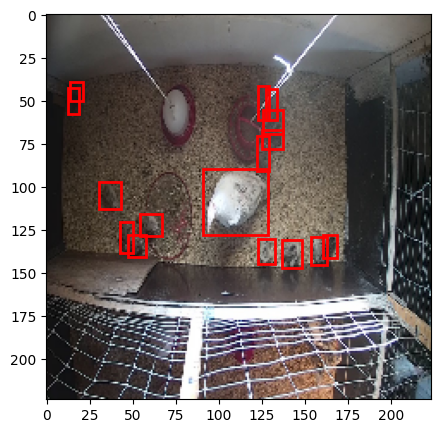

In [15]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
  

    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[68]
plot_img_bbox(img, target)

In [16]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model
    

In [26]:
dataset = CustomDataset(files_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = CustomDataset(files_dir, 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [24]:
dataset = CustomDataset(files_dir, 480, 480, transforms= get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 3
print(device)
model = get_object_detection_model(num_classes)
model.to(device)

cuda


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 57.9MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [19]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [20]:
# For Training
# just checking the trainng 
# images,targets = next(iter(data_loader))
# print(type(targets))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets) 
# print((output))

<class 'tuple'>


RuntimeError: ignored

In [23]:
num_epochs = 10

for epoch in range(num_epochs):

  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  lr_scheduler.step()
  
  evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/40]  eta: 0:02:21  lr: 0.000000  loss: 0.1025 (0.1025)  loss_classifier: 0.0381 (0.0381)  loss_box_reg: 0.0613 (0.0613)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0029 (0.0029)  time: 3.5255  data: 1.5164  max mem: 8380
Epoch: [0]  [10/40]  eta: 0:00:56  lr: 0.000001  loss: 0.0876 (0.0891)  loss_classifier: 0.0355 (0.0351)  loss_box_reg: 0.0508 (0.0510)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0026 (0.0025)  time: 1.8737  data: 0.1766  max mem: 8381
Epoch: [0]  [20/40]  eta: 0:00:36  lr: 0.000003  loss: 0.0876 (0.0894)  loss_classifier: 0.0355 (0.0356)  loss_box_reg: 0.0496 (0.0508)  loss_objectness: 0.0004 (0.0005)  loss_rpn_box_reg: 0.0026 (0.0026)  time: 1.7251  data: 0.0421  max mem: 8381
Epoch: [0]  [30/40]  eta: 0:00:17  lr: 0.000004  loss: 0.0902 (0.0897)  loss_classifier: 0.0354 (0.0354)  loss_box_reg: 0.0516 (0.0512)  loss_objectness: 0.0003 (0.0005)  loss_rpn_box_reg: 0.0028 (0.0026)  time: 1.7578  data: 0.0421  max mem: 8381
Epoch: [

In [25]:
num_epochs = 3

for epoch in range(num_epochs):

  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  lr_scheduler.step()
  
  # evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/250]  eta: 0:06:51  lr: 0.000000  loss: 0.0681 (0.0681)  loss_classifier: 0.0302 (0.0302)  loss_box_reg: 0.0359 (0.0359)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0018 (0.0018)  time: 1.6453  data: 1.0278  max mem: 8381
Epoch: [0]  [ 10/250]  eta: 0:02:31  lr: 0.000000  loss: 0.0942 (0.0899)  loss_classifier: 0.0324 (0.0333)  loss_box_reg: 0.0561 (0.0536)  loss_objectness: 0.0002 (0.0004)  loss_rpn_box_reg: 0.0026 (0.0027)  time: 0.6314  data: 0.1239  max mem: 8381
Epoch: [0]  [ 20/250]  eta: 0:01:56  lr: 0.000000  loss: 0.0918 (0.0867)  loss_classifier: 0.0309 (0.0320)  loss_box_reg: 0.0514 (0.0518)  loss_objectness: 0.0002 (0.0003)  loss_rpn_box_reg: 0.0025 (0.0026)  time: 0.4484  data: 0.0219  max mem: 8381
Epoch: [0]  [ 30/250]  eta: 0:01:41  lr: 0.000000  loss: 0.0892 (0.0877)  loss_classifier: 0.0316 (0.0332)  loss_box_reg: 0.0470 (0.0515)  loss_objectness: 0.0002 (0.0004)  loss_rpn_box_reg: 0.0026 (0.0026)  time: 0.3666  data: 0.0104  max mem: 8381


KeyboardInterrupt: ignored

In [44]:
# pick one image from the test set
img, target = dataset_test[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  16
real #boxes:  16


In [45]:
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

EXPECTED OUTPUT


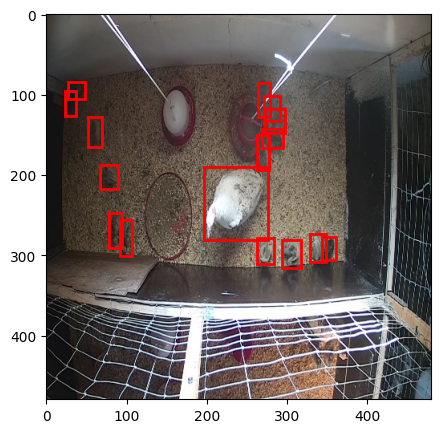

In [46]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


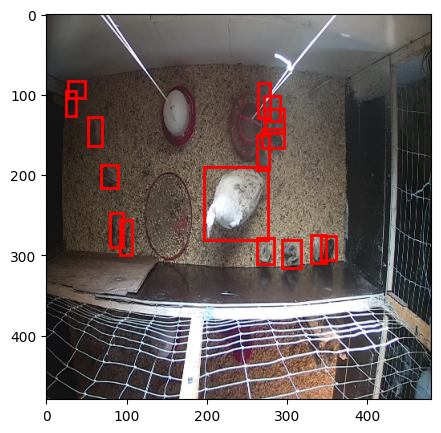

In [47]:
prediction = {key: tensor.cpu() for key, tensor in prediction.items()}
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)